In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from keras import callbacks
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import time
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
#for loading dataset from google drive 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab_Notebooks/

%ls

/content/drive/My Drive/Colab_Notebooks
'Copy of TensorFlow-Introduction.ipynb'    hw32/
'Copy of YOLOv4_Training_Tutorial.ipynb'   KDDTest+.txt
 hw12.ipynb                                KDDTrain+.txt
 hw13.ipynb                                model1.h5
 hw14.ipynb                                UNSW_NB15_testing-set.csv
 hw15.ipynb                                UNSW_NB15_training-set.csv
 hw1.ipynb                                 Untitled0.ipynb
 hw2/                                      Untitled1.ipynb
 hw3/                                      Untitled2.ipynb


In [4]:
feature_list = ["F"+str(i) for i in range(1,43)]
nsl_kdd = pd.read_csv ('KDDTrain+.txt' , names =feature_list )
nsl_kdd_test = pd.read_csv('KDDTest+.txt',names =feature_list )


In [5]:
print("len of attack types for train data set is "+str(len(nsl_kdd.value_counts('F41'))))
print(nsl_kdd.value_counts('F41'))
print("___________________________________________________")
print("len of attack types for test data set is "+str(len(nsl_kdd_test.value_counts('F41'))))
nsl_kdd_test.value_counts('F41')

len of attack types for train data set is 23
F41
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
dtype: int64
___________________________________________________
len of attack types for test data set is 38


F41
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
phf                   2
udpstorm              2
sqlattack             2
perl                  2
loadmodule            2
imap                  1
dtype: int64

In [6]:
DoS=['apache2', 'smurf', 'neptune', 'back', 'teardrop', 'pod',
'Land', 'Mailbomb', 'Processtable', 'UDPstorm']#1
DoS = [x.lower() for x in DoS]
R2L = ['WarezClient', 'guess_passwd', 'WarezMaster',
'Imap', 'Ftp_Write', 'Named', 'MultiHop', 'Phf', 'Spy',
'Sendmail', 'SnmpGetAttack', 'SnmpGuess',
'Worm', 'Xsnoop', 'Xlock']#2
R2L = [x.lower() for x in R2L]
U2R = ['Buffer_Overflow', 'httptunnel', 'Rootkit',
'LoadModule', 'Perl', 'Xterm', 'Ps', 'SQLattack']
U2R = [x.lower() for x in U2R]#3
probe = ['Satan', 'Saint', 'Ipsweep', 'Portsweep', 'Nmap',
'Mscan']#4
probe = [x.lower() for x in probe]

# classifing attack type to 5 group in train data 
attack_type = [] 
for item  in nsl_kdd["F41"] :
  if item in DoS :
    attack_type.append(1)#DoS
  elif item in R2L :
    attack_type.append(2)#R2L
  elif item in U2R :
    attack_type.append(3)#U2R
  elif item in probe :
    attack_type.append(4)#"probe"
  elif item == 'normal' :
    attack_type.append(0)#normal
  else :
    print(item)

nsl_kdd['attack_type']  = attack_type

# classifing attack type to 5 group in test data 
attack_type = [] 
for item  in nsl_kdd_test["F41"] :
  if item in DoS :
    attack_type.append(1)#DoS
  elif item in R2L :
    attack_type.append(2)#R2L
  elif item in U2R :
    attack_type.append(3)#U2R
  elif item in probe :
    attack_type.append(4)#"probe"
  elif item == 'normal' :
    attack_type.append(0)#normal
  else :
    print(item)
    
nsl_kdd_test['attack_type']  = attack_type


In [7]:
nsl_kdd_test = nsl_kdd_test.loc[:, nsl_kdd_test.columns !=  'F41' ]
nsl_kdd = nsl_kdd.loc[:, nsl_kdd.columns !=  'F41' ]

nsl_kdd

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F33,F34,F35,F36,F37,F38,F39,F40,F42,attack_type
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
0,udp,other,SF,146,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
0,tcp,private,S0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
0,tcp,http,SF,232,8153,0,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
0,tcp,http,SF,199,420,0,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,tcp,private,S0,0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20,1
8,udp,private,SF,105,145,0,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,21,0
0,tcp,smtp,SF,2231,384,0,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,18,0
0,tcp,klogin,S0,0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,20,1


In [8]:
nsl_kdd_test

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F33,F34,F35,F36,F37,F38,F39,F40,F42,attack_type
0,tcp,private,REJ,0,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
0,tcp,private,REJ,0,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,21,0
0,icmp,eco_i,SF,20,0,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,15,4
1,tcp,telnet,RSTO,0,15,0,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,tcp,smtp,SF,794,333,0,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,21,0
0,tcp,http,SF,317,938,0,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,21,0
0,tcp,http,SF,54540,8314,0,0,0,2,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,15,1
0,udp,domain_u,SF,42,42,0,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,21,0


In [ ]:
print(nsl_kdd.shape)
nsl_kdd.info()

(125973, 42)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125973 entries, 0 to 0
Data columns (total 42 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   F1           125973 non-null  object 
 1   F2           125973 non-null  object 
 2   F3           125973 non-null  object 
 3   F4           125973 non-null  int64  
 4   F5           125973 non-null  int64  
 5   F6           125973 non-null  int64  
 6   F7           125973 non-null  int64  
 7   F8           125973 non-null  int64  
 8   F9           125973 non-null  int64  
 9   F10          125973 non-null  int64  
 10  F11          125973 non-null  int64  
 11  F12          125973 non-null  int64  
 12  F13          125973 non-null  int64  
 13  F14          125973 non-null  int64  
 14  F15          125973 non-null  int64  
 15  F16          125973 non-null  int64  
 16  F17          125973 non-null  int64  
 17  F18          125973 non-null  int64  
 18  F19          125

In [ ]:
# print(nsl_kdd_test.shape)
# nsl_kdd_test.info()

In [9]:
cat_columns = nsl_kdd.select_dtypes(['object']).columns
cat_columns

Index(['F1', 'F2', 'F3'], dtype='object')

In [10]:
#categorical to numeric
for col_name in cat_columns :
      nsl_kdd[col_name]= nsl_kdd[col_name].astype('category')
      nsl_kdd[col_name] = nsl_kdd[col_name].cat.codes
      #_______
      #df_UNSW_test
      nsl_kdd_test[col_name]= nsl_kdd_test[col_name].astype('category')
      nsl_kdd_test[col_name] = nsl_kdd_test[col_name].cat.codes

nsl_kdd_test

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F33,F34,F35,F36,F37,F38,F39,F40,F42,attack_type
0,1,45,1,0,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
0,1,45,1,0,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1
2,1,19,9,12983,0,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,21,0
0,0,13,9,20,0,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,15,4
1,1,55,2,0,15,0,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,49,9,794,333,0,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,21,0
0,1,22,9,317,938,0,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,21,0
0,1,22,9,54540,8314,0,0,0,2,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,15,1
0,2,11,9,42,42,0,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,21,0


In [11]:
nsl_kdd_y = nsl_kdd['attack_type']
nsl_kdd_x = nsl_kdd.loc[:, nsl_kdd.columns !=  'attack_type' ]

nsl_kdd_y_test = nsl_kdd_test['attack_type']
nsl_kdd_x_test = nsl_kdd_test.loc[:, nsl_kdd_test.columns !=  'attack_type' ]


In [ ]:
# nsl_kdd_y_test.value_counts()

In [12]:
#Normalization
all_cols = nsl_kdd_x.columns
scaler = MinMaxScaler(feature_range=(0, 1))
nsl_kdd_x[all_cols] =  MinMaxScaler().fit_transform(nsl_kdd_x[all_cols])

#____test____
all_cols = nsl_kdd_x_test.columns
scaler = MinMaxScaler(feature_range=(0, 1))
nsl_kdd_x_test[all_cols] =  scaler.fit_transform(nsl_kdd_x_test[all_cols])
nsl_kdd_x_test

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F32,F33,F34,F35,F36,F37,F38,F39,F40,F42
0,0.5,0.714286,0.1,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.039216,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1.000000
0,0.5,0.714286,0.1,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.003922,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1.000000
2,0.5,0.301587,0.9,2.066513e-04,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.337255,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,1.000000
0,0.0,0.206349,0.9,3.183413e-07,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.223529,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,0.714286
1,0.5,0.873016,0.2,0.000000e+00,0.000011,0.0,0.0,0.0,0.000000,0.0,...,0.337255,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.5,0.777778,0.9,1.263815e-05,0.000247,0.0,0.0,0.0,0.000000,0.0,...,0.552941,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,1.000000
0,0.5,0.349206,0.9,5.045710e-06,0.000697,0.0,0.0,0.0,0.000000,0.0,...,1.000000,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,1.000000
0,0.5,0.349206,0.9,8.681168e-04,0.006177,0.0,0.0,0.0,0.019802,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,0.714286
0,1.0,0.174603,0.9,6.685168e-07,0.000031,0.0,0.0,0.0,0.000000,0.0,...,0.988235,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,1.000000


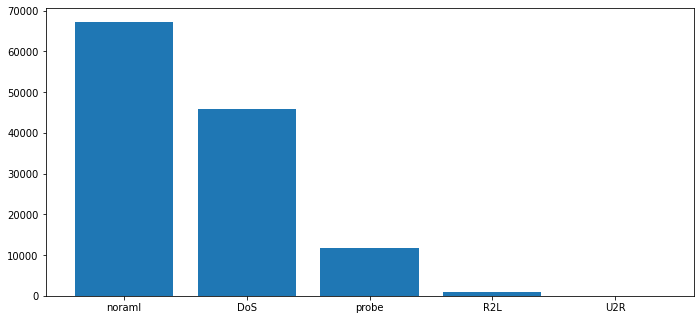

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figwidth(9)
ax = fig.add_axes([0,0,1,1])
classnames = ['noraml','DoS','probe','R2L' ,'U2R' ]
freq = nsl_kdd_y.value_counts()
ax.bar(classnames,freq)
plt.show()

In [28]:
def creat_bias_list(y):
  
  freq_dic = y.value_counts().to_dict()
  # print(freq_dic)

  bias_item = {}
  for item in freq_dic :
    bias_item[item ] = math.log(freq_dic[item]/sum(nsl_kdd_y.value_counts()))
  bias_item_list = []
  for item in bias_item :
    bias_item_list.append(bias_item[item])
  return bias_item_list

def bias_init(bias_item_list):
    return keras.backend.variable(bias_item_list)


def make_model(activation , optimizer , n_of_input, n_of_output,bias_item_list) :

  model = Sequential();
  model.add(tf.keras.Input(shape=(n_of_input,)))#41
  model.add(tf.keras.layers.Dropout(0.2, input_shape=(41,)))#
  model.add(tf.keras.layers.Dense(units = 128 , activation = activation , kernel_initializer='he_normal' ))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Dense(units = 64 , activation = activation ))
  model.add(tf.keras.layers.Dense(units = 32 , activation = activation ))
  model.add(tf.keras.layers.Dense(units = n_of_output , activation = 'softmax'  ,  bias_initializer= tf.keras.initializers.Constant(bias_item_list)) )#5
  
  if optimizer == 'adam' :
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  else :
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),  metrics=['accuracy'] ,  optimizer=opt  )
  return model

def make_model_4(activation , optimizer , n_of_input, n_of_output,bias_item_list) :

  model = Sequential();
  model.add(tf.keras.Input(shape=(n_of_input,)))#41
  model.add(tf.keras.layers.Dropout(0.15, input_shape=(41,)))#
  model.add(tf.keras.layers.Dense(units = 256 , activation = activation , kernel_initializer='he_normal' ))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Dense(units = 128 , activation = activation ))
  model.add(BatchNormalization())
  model.add(tf.keras.layers.Dense(units = 64 , activation = activation ))
  model.add(tf.keras.layers.Dense(units = 32 , activation = activation ))
  model.add(tf.keras.layers.Dense(units = n_of_output , activation = 'softmax'  ,  bias_initializer= tf.keras.initializers.Constant(bias_item_list)) )#5
  
  if optimizer == 'adam' :
    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
  else :
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),  metrics=['accuracy'] ,  optimizer=opt  )
  return model

def fit_model(n_of_epoch, batchsize , x_train , y_train ,X_val , y_val , model  ):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val) ,epochs= n_of_epoch, verbose=1,batch_size= batchsize)
  return history

def evaluate_test(model, x_test , y_test , batchsize ) :
  result = model.evaluate(x_test, y_test, batch_size=batchsize, verbose = 1 )
  return result 
def predict_yhat (model , x ) :
  prediction = model.predict(x[:])
  class_predictions=np.argmax(prediction,axis=1)#y hat
  y_hat = class_predictions
  return y_hat



In [18]:
def plot_loss_train_validation(history) :
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['loss'])
  plt.legend(["val_loss","loss"])
  return plt

def plot_accuracy_train_validation(history):
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['accuracy'])
  plt.legend(["val_accuracy","accuracy"])
  return plt



def plot_confusion_matrix (y , y_hat  , class_names):

  conmat = confusion_matrix(y ,y_hat)
  val = np.mat(conmat) 
  df_cm = pd.DataFrame(val, index=class_names, columns=class_names)

  plt.figure()
  heatmap = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  return plt

def accuracy_of_classes(classnames , y, y_hat) :
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y ,y_hat)
  print( "accuracy of each class : ")
  acc_of_classes  = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
  for i in range(len(classnames)) :
    print("accuracy of ", classnames[i] , "is : " , acc_of_classes[i])

def truePositiveRate_of_classes(y , y_hat , classnames):
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y ,y_hat)
  #https://stackoverflow.com/questions/47899463/how-to-extract-false-positive-false-negative-from-a-confusion-matrix-of-multicl
  print( "\ntruePositive rate of each class :")
  truePositive = np.diag(confusion_matrix)
  FalseNegative = []
  for i in range(len(classnames)):
      FalseNegative.append(sum(confusion_matrix[i,:]) - confusion_matrix[i,i])
  FalseNegative

  truePositiveRate = [None]*len(classnames)
  for i in range( len(truePositive )):
    truePositiveRate[i] = truePositive[i] / (truePositive[i] + FalseNegative[i])# tp/(tp+fn)
    print( "true positive rate of" ,  classnames[i], "is : ", truePositiveRate[i])

def FalsePositiveRate(y , y_hat , classnames) :
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y ,y_hat)
  print( "\nFalsePositive rate of each class :  ")
  FalsePositive = []
  for i in range(len(classnames)):
      FalsePositive.append(sum(confusion_matrix[:,i]) - confusion_matrix[i,i])
      # print(FalsePositive , i)


  TrueNegative = []
  for i in range(len(classnames)):
      temp = np.delete(confusion_matrix, i, 0)   # delete ith row
      temp = np.delete(temp, i, 1)  # delete ith column
      TrueNegative.append(sum(sum(temp)))
      # print(TrueNegative , i)

  FalsePositiveRate = [None]*len(classnames)
  for i in range( len(FalsePositive )):
    FalsePositiveRate[i] = FalsePositive[i] / (FalsePositive[i] + TrueNegative[i])# 
    print( "false positive rate of" ,  classnames[i], "is : ", FalsePositiveRate[i])



  



In [19]:
activation_optimizer_dic = [ 
                  {'activation' :'relu', 'optimizer' : 'RMS Prop'  },{'activation' :'relu', 'optimizer' : 'adam' },
                  {'activation' :'elu', 'optimizer' : 'RMS Prop' },{'activation' :'elu', 'optimizer' : 'adam' }
]
#_____________________train model________________________

X_train, X_val, y_train, y_val = train_test_split(nsl_kdd_x, nsl_kdd_y, 
    test_size=0.10, random_state= 8)
activation_function = activation_optimizer_dic[0]['activation']
optimizer = activation_optimizer_dic[0]['optimizer']
print('**make model with 3 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 4096 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)



**make model with 3 layer and activation function  relu optimizer :  RMS Prop
**fit modelwith 3 layer and activation function  relu optimizer :  RMS Prop
Epoch 1/40
28/28 [==============================] - 3s 70ms/step - loss: 9.9821 - accuracy: 0.7539 - val_loss: 0.6650 - val_accuracy: 0.9027
Epoch 2/40
28/28 [==============================] - 1s 42ms/step - loss: 0.4495 - accuracy: 0.8927 - val_loss: 0.3634 - val_accuracy: 0.8543
Epoch 3/40
28/28 [==============================] - 1s 47ms/step - loss: 0.3573 - accuracy: 0.8647 - val_loss: 1.4634 - val_accuracy: 0.6945
Epoch 4/40
28/28 [==============================] - 1s 53ms/step - loss: 0.6619 - accuracy: 0.8426 - val_loss: 0.2458 - val_accuracy: 0.9478
Epoch 5/40
28/28 [==============================] - 2s 56ms/step - loss: 0.2107 - accuracy: 0.9438 - val_loss: 0.1843 - val_accuracy: 0.9419
Epoch 6/40
28/28 [==============================] - 1s 28ms/step - loss: 0.3292 - accuracy: 0.9252 - val_loss: 0.2689 - val_accuracy: 0.9317


In [ ]:
# model.save('model1.h5')
# print('Model Saved!')
 
# load model

savedModel=load_model('model1.h5')
savedModel.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 41)                0         
                                                                 
 dense_64 (Dense)            (None, 128)               5376      
                                                                 
 batch_normalization_14 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_65 (Dense)            (None, 64)                8256      
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 5)                 165       
                                                     

In [ ]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 4ms/step - loss: 5.8465 - accuracy: 0.5122
**for model with 3 layer and activation function  relu optimizer :  RMS Prop
test loss, test acc: [5.846511363983154, 0.5121539831161499]
**and time for testing this model is : 0.8078362941741943


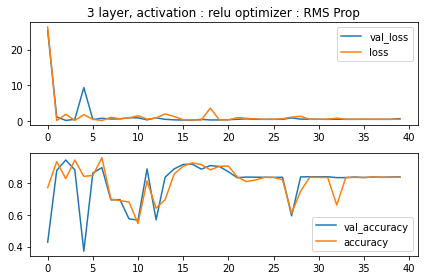

In [ ]:

plt.subplot(2, 1, 1)

title = "3 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 3 layer, activation : relu, optimizer : RMS Prop')

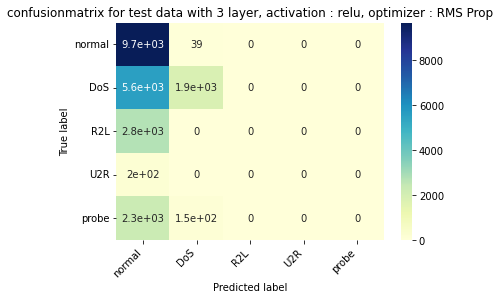

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [ ]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusionmatrix for test data with 3 layer, activation : relu, optimizer : RMS Prop **
---for test data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9959839357429718
accuracy of  DoS is :  0.25127379994636634
accuracy of  probe is :  0.0
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0

truePositive rate of each class :
true positive rate of noraml is :  0.9959839357429718
true positive rate of DoS is :  0.25127379994636634
true positive rate of probe is :  0.0
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0

FalsePositive rate of each class :  
false positive rate of noraml is :  0.842281617704356
false positive rate of DoS is :  0.012528171814927748
false positive rate of probe is :  0.0
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.0


In [ ]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** 3 layer, activation : relu, optimizer : RMS Prop **
---for train data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9974904592904978
accuracy of  DoS is :  0.8272911359331112
accuracy of  probe is :  0.0
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0

truePositive rate of each class :
true positive rate of noraml is :  0.9974904592904978
true positive rate of DoS is :  0.8272911359331112
true positive rate of probe is :  0.0
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0

FalsePositive rate of each class :  
false positive rate of noraml is :  0.333464096878731
false positive rate of DoS is :  0.015653499237938184
false positive rate of probe is :  0.0
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.0


Text(0.5, 1.0, 'confusionmatrix for train data with 3 layer, activation : relu, optimizer : RMS Prop')

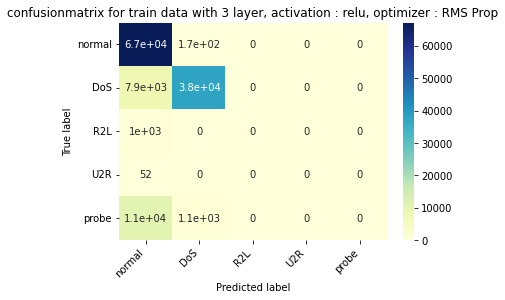

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
#_____________________________________________________________________________
# for second 

In [ ]:
activation_function = activation_optimizer_dic[1]['activation']
optimizer = activation_optimizer_dic[1]['optimizer']
print('**make model with 3 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 4096 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 3 layer and activation function  relu optimizer :  adam
**fit modelwith 3 layer and activation function  relu optimizer :  adam
Epoch 1/40
28/28 [==============================] - 2s 29ms/step - loss: 0.9582 - accuracy: 0.8410 - val_loss: 1.1210 - val_accuracy: 0.8412
Epoch 2/40
28/28 [==============================] - 1s 22ms/step - loss: 0.0970 - accuracy: 0.9681 - val_loss: 1.6011 - val_accuracy: 0.8455
Epoch 3/40
28/28 [==============================] - 1s 28ms/step - loss: 0.0491 - accuracy: 0.9816 - val_loss: 1.1733 - val_accuracy: 0.8593
Epoch 4/40
28/28 [==============================] - 1s 37ms/step - loss: 0.0325 - accuracy: 0.9888 - val_loss: 0.6281 - val_accuracy: 0.8796
Epoch 5/40
28/28 [==============================] - 1s 41ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.4133 - val_accuracy: 0.9038
Epoch 6/40
28/28 [==============================] - 1s 41ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0778 - val_accuracy: 0.9716
Epoch 7/

In [ ]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 7ms/step - loss: 4.3649 - accuracy: 0.7913
**for model with 3 layer and activation function  relu optimizer :  adam
test loss, test acc: [4.364867687225342, 0.7913413643836975]
**and time for testing this model is : 2.756028413772583


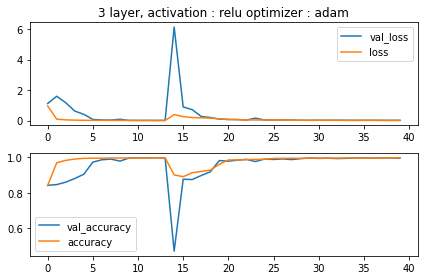

In [ ]:
plt.subplot(2, 1, 1)

title = "3 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 3 layer, activation : relu, optimizer : adam')

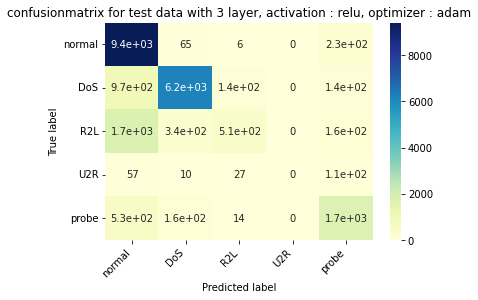

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

Text(0.5, 1.0, 'confusion matrix for train data with 3 layer, activation : relu, optimizer : adam')

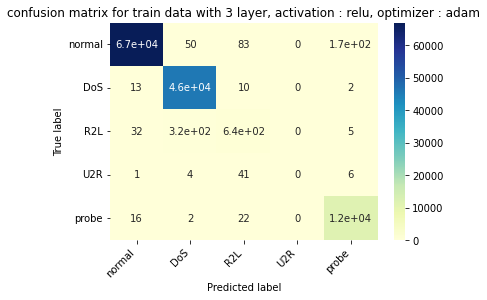

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusionmatrix for test data with 3 layer, activation : relu, optimizer : adam **
---for test data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9691071980228607
accuracy of  DoS is :  0.8323947438991687
accuracy of  probe is :  0.18482207697893974
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.7071458075175547

truePositive rate of each class :
true positive rate of noraml is :  0.9691071980228607
true positive rate of DoS is :  0.8323947438991687
true positive rate of probe is :  0.18482207697893974
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.7071458075175547

FalsePositive rate of each class :  
false positive rate of noraml is :  0.2569936881477441
false positive rate of DoS is :  0.03851252817181493
false positive rate of probe is :  0.009550277918140474
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.03160562540376683


In [ ]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusionmatrix for test data with 3 layer, activation : relu, optimizer : adam **
---for train data--- 
accuracy of each class : 
accuracy of  noraml is :  0.995500645946869
accuracy of  DoS is :  0.9994556578918719
accuracy of  probe is :  0.6422110552763819
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.9965682910089224

truePositive rate of each class :
true positive rate of noraml is :  0.995500645946869
true positive rate of DoS is :  0.9994556578918719
true positive rate of probe is :  0.6422110552763819
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.9965682910089224

FalsePositive rate of each class :  
false positive rate of noraml is :  0.001057479106259594
false positive rate of DoS is :  0.004684806236414062
false positive rate of probe is :  0.001248219686664853
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.001600811777775834


In [ ]:
#_________________________________________________________________________

In [ ]:
activation_function = activation_optimizer_dic[2]['activation']
optimizer = activation_optimizer_dic[2]['optimizer']
print('**make model with 3 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 4096 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 3 layer and activation function  elu optimizer :  RMS Prop
**fit modelwith 3 layer and activation function  elu optimizer :  RMS Prop
Epoch 1/40
28/28 [==============================] - 3s 55ms/step - loss: 37.1147 - accuracy: 0.7771 - val_loss: 9.8960 - val_accuracy: 0.8110
Epoch 2/40
28/28 [==============================] - 1s 36ms/step - loss: 1.0926 - accuracy: 0.8794 - val_loss: 5.8876 - val_accuracy: 0.7670
Epoch 3/40
28/28 [==============================] - 1s 26ms/step - loss: 0.3800 - accuracy: 0.8899 - val_loss: 7.7818 - val_accuracy: 0.5498
Epoch 4/40
28/28 [==============================] - 1s 26ms/step - loss: 1.4564 - accuracy: 0.8460 - val_loss: 4.3307 - val_accuracy: 0.8001
Epoch 5/40
28/28 [==============================] - 1s 51ms/step - loss: 1.4748 - accuracy: 0.8171 - val_loss: 6.7286 - val_accuracy: 0.3658
Epoch 6/40
28/28 [==============================] - 1s 28ms/step - loss: 0.8039 - accuracy: 0.8196 - val_loss: 0.6028 - val_accuracy: 0.8369
E

In [ ]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 6ms/step - loss: 27.2705 - accuracy: 0.6639
**for model with 3 layer and activation function  elu optimizer :  RMS Prop
test loss, test acc: [27.27045249938965, 0.6639460325241089]
**and time for testing this model is : 0.8540098667144775


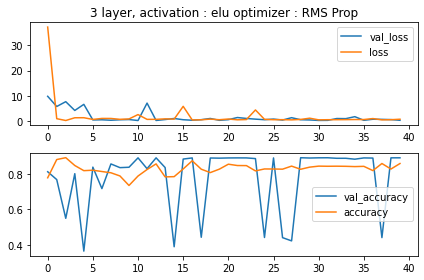

In [ ]:
plt.subplot(2, 1, 1)

title = "3 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 3 layer, activation : elu, optimizer : RMS Prop')

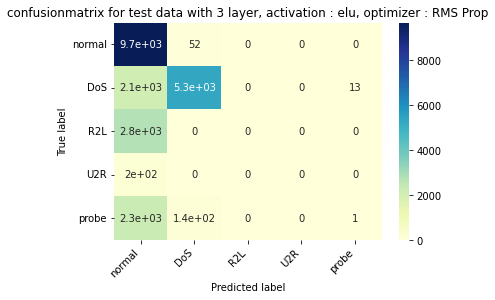

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

Text(0.5, 1.0, 'confusion matrix for train data with 3 layer, activation : elu, optimizer : RMS Prop')

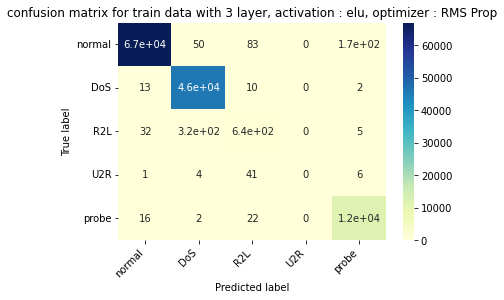

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusion matrix for train data with 3 layer, activation : elu, optimizer : RMS Prop **
---for test data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9946452476572959
accuracy of  DoS is :  0.7117189595065702
accuracy of  probe is :  0.0
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0004130524576621231

truePositive rate of each class :
true positive rate of noraml is :  0.9946452476572959
true positive rate of DoS is :  0.7117189595065702
true positive rate of probe is :  0.0
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0004130524576621231

FalsePositive rate of each class :  
false positive rate of noraml is :  0.5741447829813762
false positive rate of DoS is :  0.012925891555084184
false positive rate of probe is :  0.0
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.0006460269343537246


In [ ]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusion matrix for train data with 3 layer, activation : elu, optimizer : RMS Prop **
---for train data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9997475609937188
accuracy of  DoS is :  0.9756787946088358
accuracy of  probe is :  0.0
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0026595744680851063

truePositive rate of each class :
true positive rate of noraml is :  0.9997475609937188
true positive rate of DoS is :  0.9756787946088358
true positive rate of probe is :  0.0
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0026595744680851063

FalsePositive rate of each class :  
false positive rate of noraml is :  0.2345556882142248
false positive rate of DoS is :  0.00048721984858706243
false positive rate of probe is :  0.0
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.00013121408014556016


In [ ]:
#_________________________________________________________________________

In [ ]:
activation_function = activation_optimizer_dic[3]['activation']
optimizer = activation_optimizer_dic[3]['optimizer']
print('**make model with 3 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 4096 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 3 layer and activation function  elu optimizer :  adam
**fit modelwith 3 layer and activation function  elu optimizer :  adam
Epoch 1/40
28/28 [==============================] - 2s 32ms/step - loss: 4.2827 - accuracy: 0.7486 - val_loss: 20.0404 - val_accuracy: 0.5696
Epoch 2/40
28/28 [==============================] - 1s 26ms/step - loss: 0.2330 - accuracy: 0.9361 - val_loss: 0.9651 - val_accuracy: 0.7736
Epoch 3/40
28/28 [==============================] - 1s 26ms/step - loss: 0.1120 - accuracy: 0.9634 - val_loss: 0.6306 - val_accuracy: 0.8397
Epoch 4/40
28/28 [==============================] - 1s 25ms/step - loss: 0.0688 - accuracy: 0.9752 - val_loss: 0.8201 - val_accuracy: 0.8659
Epoch 5/40
28/28 [==============================] - 1s 26ms/step - loss: 0.0458 - accuracy: 0.9858 - val_loss: 0.6048 - val_accuracy: 0.8864
Epoch 6/40
28/28 [==============================] - 1s 26ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.3365 - val_accuracy: 0.8980
Epoch 7/4

In [ ]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 3 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 6ms/step - loss: 2.2448 - accuracy: 0.8089
**for model with 3 layer and activation function  elu optimizer :  adam
test loss, test acc: [2.244816541671753, 0.8089070320129395]
**and time for testing this model is : 1.319606065750122


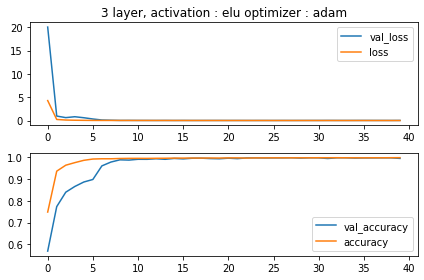

In [ ]:
plt.subplot(2, 1, 1)

title = "3 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 3 layer, activation : elu, optimizer : adam')

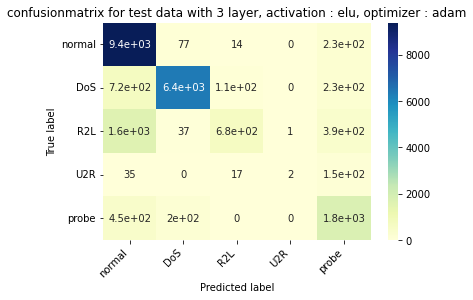

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [ ]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusion matrix for train data with 3 layer, activation : elu, optimizer : adam **
---for test data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9673566059108227
accuracy of  DoS is :  0.8576025744167337
accuracy of  probe is :  0.24655047204066813
accuracy of  R2L is :  0.01
accuracy of  U2R is :  0.7290375877736472

truePositive rate of each class :
true positive rate of noraml is :  0.9673566059108227
true positive rate of DoS is :  0.8576025744167337
true positive rate of probe is :  0.24655047204066813
true positive rate of R2L is :  0.01
true positive rate of U2R is :  0.7290375877736472

FalsePositive rate of each class :  
false positive rate of noraml is :  0.22262915919894022
false positive rate of DoS is :  0.021012859604931725
false positive rate of probe is :  0.007023749368367862
false positive rate of R2L is :  4.475474400286431e-05
false positive rate of U2R is :  0.0493962132882771


In [ ]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusion matrix for train data with 3 layer, activation : elu, optimizer : adam **
---for train data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9990050933281855
accuracy of  DoS is :  0.9993467894702462
accuracy of  probe is :  0.9256281407035176
accuracy of  R2L is :  0.057692307692307696
accuracy of  U2R is :  0.9703157172271791

truePositive rate of each class :
true positive rate of noraml is :  0.9990050933281855
true positive rate of DoS is :  0.9993467894702462
true positive rate of probe is :  0.9256281407035176
true positive rate of R2L is :  0.057692307692307696
true positive rate of U2R is :  0.9703157172271791

FalsePositive rate of each class :  
false positive rate of noraml is :  0.0075046904315197
false positive rate of DoS is :  0.00026234914923918746
false positive rate of probe is :  0.00031205492166621327
false positive rate of R2L is :  7.94148712287863e-06
false positive rate of U2R is :  0.0005685943472974273


Text(0.5, 1.0, 'confusion matrix for train data with 3 layer, activation : elu, optimizer : adam')

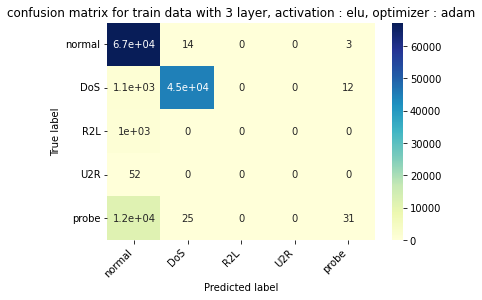

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 3 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
#_________________________________________________________________________

In [ ]:
activation_function = activation_optimizer_dic[1]['activation']
optimizer = activation_optimizer_dic[1]['optimizer']
print('**make model with 4 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model_4(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 8000 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 4 layer and activation function  relu optimizer :  adam
**fit modelwith 4 layer and activation function  relu optimizer :  adam
Epoch 1/40
15/15 [==============================] - 5s 193ms/step - loss: 13.3444 - accuracy: 0.5990 - val_loss: 21.4137 - val_accuracy: 0.3786
Epoch 2/40
15/15 [==============================] - 2s 163ms/step - loss: 0.5420 - accuracy: 0.9054 - val_loss: 1.1600 - val_accuracy: 0.8357
Epoch 3/40
15/15 [==============================] - 2s 153ms/step - loss: 0.2224 - accuracy: 0.9314 - val_loss: 1.1505 - val_accuracy: 0.8262
Epoch 4/40
15/15 [==============================] - 2s 147ms/step - loss: 0.1695 - accuracy: 0.9448 - val_loss: 1.0932 - val_accuracy: 0.8531
Epoch 5/40
15/15 [==============================] - 1s 87ms/step - loss: 0.1283 - accuracy: 0.9587 - val_loss: 0.4631 - val_accuracy: 0.9357
Epoch 6/40
15/15 [==============================] - 1s 87ms/step - loss: 0.1114 - accuracy: 0.9623 - val_loss: 0.3680 - val_accuracy: 0.9428
Ep

In [ ]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 7ms/step - loss: 8.0633 - accuracy: 0.8066
**for model with 4 layer and activation function  relu optimizer :  adam
test loss, test acc: [8.063282012939453, 0.8066447973251343]
**and time for testing this model is : 1.3988027572631836


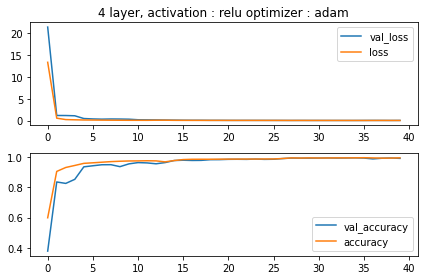

In [ ]:
plt.subplot(2, 1, 1)

title = "4 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 4 layer, activation : relu, optimizer : adam')

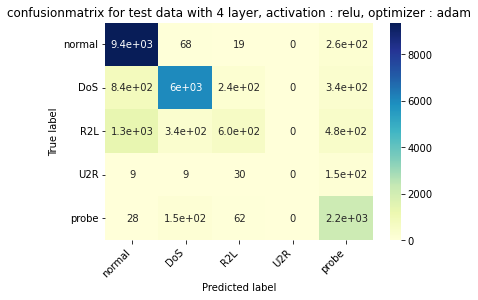

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [ ]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusion matrix for train data with 4 layer, activation : relu, optimizer : adam **
---for test data--- 
accuracy of each class : 
accuracy of  noraml is :  0.9646792297394707
accuracy of  DoS is :  0.8091981764548136
accuracy of  probe is :  0.219680464778504
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.899215200330442

truePositive rate of each class :
true positive rate of noraml is :  0.9646792297394707
true positive rate of DoS is :  0.8091981764548136
true positive rate of probe is :  0.219680464778504
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.899215200330442

FalsePositive rate of each class :  
false positive rate of noraml is :  0.17166679654016986
false positive rate of DoS is :  0.03791594856158027
false positive rate of probe is :  0.01793835270338555
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.06107439248620981


In [ ]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusion matrix for train data with 4 layer, activation : relu, optimizer : adam **
---for train data--- 
accuracy of each class : 
accuracy of  noraml is :  0.989946987808681
accuracy of  DoS is :  0.9942517473381671
accuracy of  probe is :  0.9417085427135679
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.9968256691832532

truePositive rate of each class :
true positive rate of noraml is :  0.989946987808681
true positive rate of DoS is :  0.9942517473381671
true positive rate of probe is :  0.9417085427135679
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.9968256691832532

FalsePositive rate of each class :  
false positive rate of noraml is :  0.0037352891011427597
false positive rate of DoS is :  0.00013742098293481248
false positive rate of probe is :  0.0022243914929027508
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.00507361109896166


Text(0.5, 1.0, 'confusion matrix for train data with 4 layer, activation : relu, optimizer : adam')

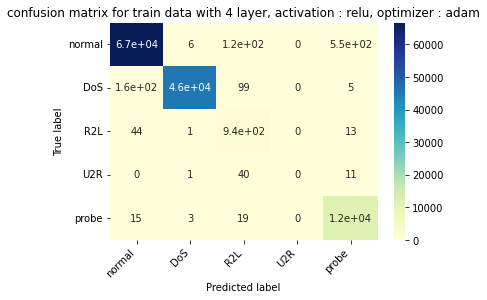

In [ ]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [16]:
#_______________model 4 __________________________________
activation_optimizer_dic = [ 
                  {'activation' :'relu', 'optimizer' : 'RMS Prop'  },{'activation' :'relu', 'optimizer' : 'adam' },
                  {'activation' :'elu', 'optimizer' : 'RMS Prop' },{'activation' :'elu', 'optimizer' : 'adam' }
]

In [29]:
activation_function = activation_optimizer_dic[0]['activation']
optimizer = activation_optimizer_dic[0]['optimizer']
print('**make model with 4 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model_4(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 8000 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 4 layer and activation function  relu optimizer :  RMS Prop
**fit modelwith 4 layer and activation function  relu optimizer :  RMS Prop
Epoch 1/40
15/15 [==============================] - 3s 134ms/step - loss: 41.3704 - accuracy: 0.5705 - val_loss: 1.4458 - val_accuracy: 0.3594
Epoch 2/40
15/15 [==============================] - 2s 114ms/step - loss: 0.9232 - accuracy: 0.8244 - val_loss: 1.6642 - val_accuracy: 0.3593
Epoch 3/40
15/15 [==============================] - 2s 101ms/step - loss: 0.6200 - accuracy: 0.8628 - val_loss: 1.8135 - val_accuracy: 0.3656
Epoch 4/40
15/15 [==============================] - 2s 100ms/step - loss: 1.2326 - accuracy: 0.7703 - val_loss: 1.6547 - val_accuracy: 0.3685
Epoch 5/40
15/15 [==============================] - 2s 109ms/step - loss: 0.5274 - accuracy: 0.8739 - val_loss: 4.1168 - val_accuracy: 0.4672
Epoch 6/40
15/15 [==============================] - 2s 119ms/step - loss: 0.4209 - accuracy: 0.9148 - val_loss: 2.8252 - val_accuracy: 

In [30]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 11ms/step - loss: 2.1032 - accuracy: 0.7011
**for model with 4 layer and activation function  relu optimizer :  RMS Prop
test loss, test acc: [2.10320782661438, 0.7011178135871887]
**and time for testing this model is : 0.8924565315246582


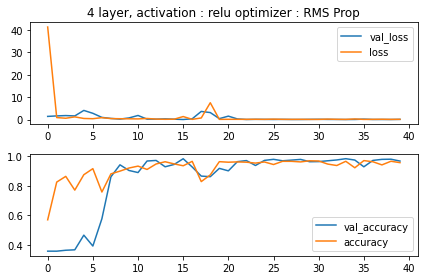

In [31]:
plt.subplot(2, 1, 1)

title = "4 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 4 layer, activation : relu, optimizer : RMS Prop')

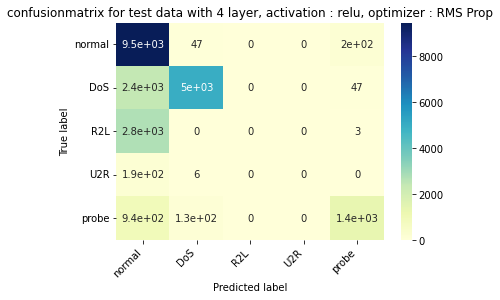

In [32]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [34]:
print("**",title,"**")
print("---for test data--- ")
classnames = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : relu, optimizer : RMS Prop **
---for test data--- 
accuracy of each class : 
accuracy of  normal is :  0.9742559983523839
accuracy of  DoS is :  0.6694824349691606
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.5584469227591904

truePositive rate of each class :
true positive rate of normal is :  0.9742559983523839
true positive rate of DoS is :  0.6694824349691606
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.5584469227591904

FalsePositive rate of each class :  
false positive rate of normal is :  0.4912335385334684
false positive rate of DoS is :  0.0119978788280525
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.012572678030114795


In [35]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : relu, optimizer : RMS Prop **
---for train data--- 
accuracy of each class : 
accuracy of  normal is :  0.9986190101421083
accuracy of  DoS is :  0.9600888366320465
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.9166094715168154

truePositive rate of each class :
true positive rate of normal is :  0.9986190101421083
true positive rate of DoS is :  0.9600888366320465
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.9166094715168154

FalsePositive rate of each class :  
false positive rate of normal is :  0.06558076070271192
false positive rate of DoS is :  0.00021237788271743748
false positive rate of R2L is :  0.0
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.0007260512434720995


Text(0.5, 1.0, 'confusion matrix for train data with 4 layer, activation : relu, optimizer : RMS Prop')

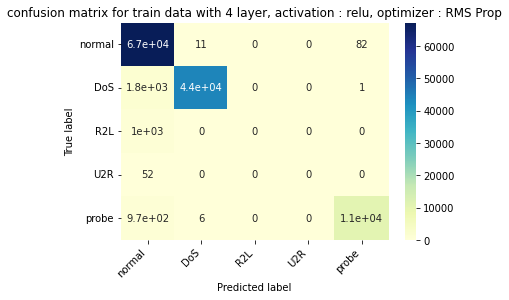

In [36]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
#_____________next___________________


In [37]:
activation_function = activation_optimizer_dic[2]['activation']
optimizer = activation_optimizer_dic[2]['optimizer']
print('**make model with 4 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model_4(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 8000 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 4 layer and activation function  elu optimizer :  RMS Prop
**fit modelwith 4 layer and activation function  elu optimizer :  RMS Prop
Epoch 1/40
15/15 [==============================] - 4s 120ms/step - loss: 92.6462 - accuracy: 0.6410 - val_loss: 45.6702 - val_accuracy: 0.7889
Epoch 2/40
15/15 [==============================] - 2s 108ms/step - loss: 1.0432 - accuracy: 0.8167 - val_loss: 12.0450 - val_accuracy: 0.8197
Epoch 3/40
15/15 [==============================] - 2s 158ms/step - loss: 0.6081 - accuracy: 0.8519 - val_loss: 4.0925 - val_accuracy: 0.8465
Epoch 4/40
15/15 [==============================] - 3s 195ms/step - loss: 2.8825 - accuracy: 0.7579 - val_loss: 2.8152 - val_accuracy: 0.8578
Epoch 5/40
15/15 [==============================] - 3s 223ms/step - loss: 1.5918 - accuracy: 0.7951 - val_loss: 0.3118 - val_accuracy: 0.8986
Epoch 6/40
15/15 [==============================] - 3s 181ms/step - loss: 0.3702 - accuracy: 0.9087 - val_loss: 0.5678 - val_accuracy: 

In [38]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 12ms/step - loss: 5.1744 - accuracy: 0.7255
**for model with 4 layer and activation function  elu optimizer :  RMS Prop
test loss, test acc: [5.1744184494018555, 0.7255145311355591]
**and time for testing this model is : 1.437272548675537


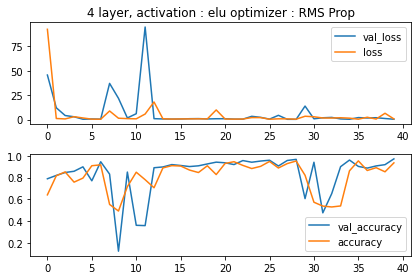

In [39]:
plt.subplot(2, 1, 1)

title = "4 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 4 layer, activation : elu, optimizer : RMS Prop')

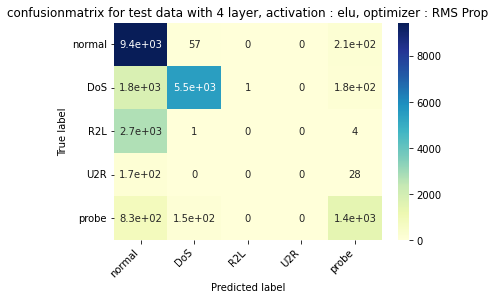

In [40]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [41]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : elu, optimizer : RMS Prop **
---for test data--- 
accuracy of each class : 
accuracy of  normal is :  0.972711358253527
accuracy of  DoS is :  0.7326360954679538
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.59727385377943

truePositive rate of each class :
true positive rate of normal is :  0.972711358253527
true positive rate of DoS is :  0.7326360954679538
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.59727385377943

FalsePositive rate of each class :  
false positive rate of normal is :  0.4333359308033975
false positive rate of DoS is :  0.013588757788678244
false positive rate of R2L is :  5.053057099545225e-05
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.020921333797147543


In [42]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : elu, optimizer : RMS Prop **
---for train data--- 
accuracy of each class : 
accuracy of  normal is :  0.9960203733127422
accuracy of  DoS is :  0.9768110261937423
accuracy of  R2L is :  0.0
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.9001372683596431

truePositive rate of each class :
true positive rate of normal is :  0.9960203733127422
true positive rate of DoS is :  0.9768110261937423
true positive rate of R2L is :  0.0
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.9001372683596431

FalsePositive rate of each class :  
false positive rate of normal is :  0.055227699130138155
false positive rate of DoS is :  0.0025860130425005624
false positive rate of R2L is :  8.001408247851621e-06
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.0008572653236176596


Text(0.5, 1.0, 'confusion matrix for train data with 4 layer, activation : elu, optimizer : RMS Prop')

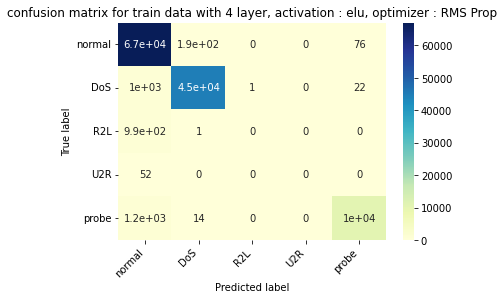

In [43]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)

In [ ]:
#_________last 

In [44]:
activation_function = activation_optimizer_dic[3]['activation']
optimizer = activation_optimizer_dic[3]['optimizer']
print('**make model with 4 layer and activation function ',activation_function , "optimizer : ",optimizer)
bias_item_list = creat_bias_list(nsl_kdd_y)
model = make_model_4(activation_function , optimizer , 41, 5,bias_item_list)
print("**fit modelwith 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
t0 = time.time()
history = fit_model(40, 8000 , X_train , y_train ,X_val , y_val , model  )
t1= time.time()
print("\n**time for training model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer,"is :", t1 - t0)

**make model with 4 layer and activation function  elu optimizer :  adam
**fit modelwith 4 layer and activation function  elu optimizer :  adam
Epoch 1/40
15/15 [==============================] - 6s 227ms/step - loss: 2.9873 - accuracy: 0.7767 - val_loss: 14.4496 - val_accuracy: 0.8986
Epoch 2/40
15/15 [==============================] - 3s 192ms/step - loss: 2.2810 - accuracy: 0.8312 - val_loss: 53.6395 - val_accuracy: 0.8075
Epoch 3/40
15/15 [==============================] - 2s 154ms/step - loss: 0.5143 - accuracy: 0.9079 - val_loss: 210.0952 - val_accuracy: 0.3637
Epoch 4/40
15/15 [==============================] - 2s 114ms/step - loss: 0.3003 - accuracy: 0.9038 - val_loss: 38.0565 - val_accuracy: 0.3733
Epoch 5/40
15/15 [==============================] - 2s 120ms/step - loss: 0.2525 - accuracy: 0.9209 - val_loss: 3.3662 - val_accuracy: 0.6195
Epoch 6/40
15/15 [==============================] - 2s 122ms/step - loss: 0.2090 - accuracy: 0.9354 - val_loss: 1.0804 - val_accuracy: 0.7717

In [45]:
result = evaluate_test(model, nsl_kdd_x_test , nsl_kdd_y_test , 2048 )
print("**for model with 4 layer and activation function ",activation_function , "optimizer : ",optimizer)
print("test loss, test acc:", result)
t0 = time.time()
y_hat= predict_yhat (model , nsl_kdd_x_test )
t1 = time.time()
print("**and time for testing this model is :" , t1 - t0 )

12/12 [==============================] - 0s 11ms/step - loss: 0.7746 - accuracy: 0.8026
**for model with 4 layer and activation function  elu optimizer :  adam
test loss, test acc: [0.7745733261108398, 0.8025638461112976]
**and time for testing this model is : 0.8958837985992432


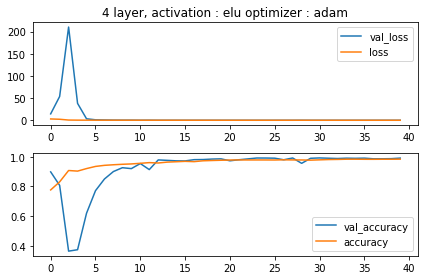

In [46]:
plt.subplot(2, 1, 1)

title = "4 layer, activation : " + activation_function +" optimizer : " + optimizer
plot_loss_train_validation(history).title(title)
plt.subplot(2, 1, 2) # index 2
plot_accuracy_train_validation(history)
plt.tight_layout()


Text(0.5, 1.0, 'confusionmatrix for test data with 4 layer, activation : elu, optimizer : adam')

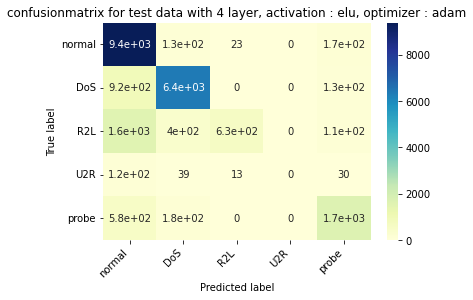

In [47]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusionmatrix for test data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y_test ,y_hat,class_names).title(title)

In [48]:
print("**",title,"**")
print("---for test data--- ")
accuracy_of_classes(classnames , nsl_kdd_y_test ,y_hat)
truePositiveRate_of_classes( nsl_kdd_y_test ,y_hat,classnames)
FalsePositiveRate(  nsl_kdd_y_test ,y_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : elu, optimizer : adam **
---for test data--- 
accuracy of each class : 
accuracy of  normal is :  0.9663268458449181
accuracy of  DoS is :  0.859077500670421
accuracy of  R2L is :  0.23021060275962238
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.6889714993804213

truePositive rate of each class :
true positive rate of normal is :  0.9663268458449181
true positive rate of DoS is :  0.859077500670421
true positive rate of R2L is :  0.23021060275962238
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.6889714993804213

FalsePositive rate of each class :  
false positive rate of normal is :  0.25060391178991664
false positive rate of DoS is :  0.04978125414291396
false positive rate of R2L is :  0.001819100555836281
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.022263082045420664


In [49]:
print("**",title,"**")
print("---for train data--- ")
predictions_list_train = model.predict(nsl_kdd_x[:])
class_predictions=np.argmax(predictions_list_train,axis=1)#y hat
ytrain_hat= class_predictions

accuracy_of_classes(classnames , nsl_kdd_y ,ytrain_hat)
truePositiveRate_of_classes( nsl_kdd_y ,ytrain_hat,classnames)
FalsePositiveRate(  nsl_kdd_y ,ytrain_hat,classnames)

** confusionmatrix for test data with 4 layer, activation : elu, optimizer : adam **
---for train data--- 
accuracy of each class : 
accuracy of  normal is :  0.9914170737864366
accuracy of  DoS is :  0.9988024473621181
accuracy of  R2L is :  0.8723618090452261
accuracy of  U2R is :  0.0
accuracy of  probe is :  0.9743479752916953

truePositive rate of each class :
true positive rate of normal is :  0.9914170737864366
true positive rate of DoS is :  0.9988024473621181
true positive rate of R2L is :  0.8723618090452261
true positive rate of U2R is :  0.0
true positive rate of probe is :  0.9743479752916953

FalsePositive rate of each class :  
false positive rate of normal is :  0.007845812723861504
false positive rate of DoS is :  0.0032981035904354997
false positive rate of R2L is :  0.0016562915073052857
false positive rate of U2R is :  0.0
false positive rate of probe is :  0.001574568961746722


Text(0.5, 1.0, 'confusion matrix for train data with 4 layer, activation : elu, optimizer : adam')

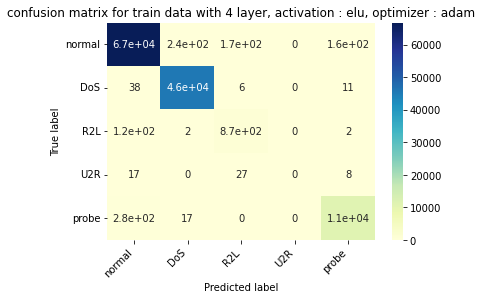

In [50]:
class_names = np.array(['normal','DoS', 'R2L' ,'U2R' ,'probe'])
title =  "confusion matrix for train data with 4 layer, activation : " + activation_function +", optimizer : " + optimizer
plot_confusion_matrix(nsl_kdd_y ,ytrain_hat,class_names).title(title)